# Experimenting with Multivariate LSTM and indices...

I'm reading a datafile with all the REPSOL indices that we were computing using the 9th floor Spark processes. We will try to predict if the vlaue will go 'Up' or 'Down'.

In [55]:
import numpy
import math
import yaml
import os
import matplotlib.pyplot as plt

from pandas import read_csv, concat, DataFrame
from numpy import concatenate
from numpy.random import seed

from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


set_random_seed(2)
seed(2)
scaler = MinMaxScaler(feature_range=(-1, 1))

### Set & Adjust parameters, and input dataset read from CSV file functions

    Input <-  Path
    Output -> raw_dataset

In [2]:
def read_parameters():
    """
    Reads a YAML file within the CWD of the current notebook to read all the params from there.
    """
    yaml_file = os.path.join(os.getcwd(), 'params.yaml')
    with open(yaml_file, 'r') as f:
        params = yaml.load(f)
    return params

In [3]:
def adjust_parameters(params):
    params['raw_adjusted_numrows'] = params['raw_numrows'] - ((params['raw_numrows'] - params['look_back']) % params['lstm_batch_size'])
    params['reframed_numrows'] = (params['raw_adjusted_numrows'] - params['look_back'])
    params['train_numrows'] = params['reframed_numrows'] - (params['test_numbatches'] * params['lstm_batch_size'])
    params['test_numrows']  = (params['test_numbatches'] * params['lstm_batch_size'])

In [4]:
def read_dataset(params):
    raw_dataset = read_csv(params['file_path'], 
                           header='infer', 
                           delimiter=params['delimiter'], 
                           usecols=params['columNames'])
    # Remove the first column as it contains the value we want to predict
    # dataset = raw_dataset.iloc[:, 1:] 
    params['raw_numrows'] = raw_dataset.shape[0]
    return(raw_dataset)

### Series-To_Supervised

This function is KEY as it produces the array shaped with t-n look-back samples to feed the LSTM

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Scale > Reframe > Drop

Let's make things reproducible. We also convert anything that might not be a float to `float32`. Data in NN is normalized to produce equivalent responses in the different layers. We also do that in this chunk. Then, data is scaled to the range 0..1, reframed according to the syntax in `series-to-supervised` and finally, unuseful columns are removed.

In [6]:
def scale_reframe_drop(raw_dataset, params):
    # Data types conversion
    first_row = raw_dataset.shape[0] - params['raw_adjusted_numrows']
    dataset = raw_dataset[first_row:].astype('float32')

    # Reframe
    reframed = series_to_supervised(dataset, params['look_back'], params['look_forward'])

    # Drop 'num_features - 1' from the tail of each row, as I only want to keep the first one, 
    # which will be what I want to predict.
    num_features = int(reframed.shape[1] / (params['look_back'] + 1))
    num_cols = reframed.shape[1]
    cols_to_remove = [reframed.columns[col_idx] for col_idx in range(num_cols - num_features + 1, num_cols)]
    prepared_dataset = reframed.drop(cols_to_remove, axis=1)
    
    # Scale
    scaled = scaler.fit_transform(prepared_dataset)
    df = DataFrame(data=scaled[:,:], index=range(0,scaled.shape[0]), 
               columns=['var-{:d}'.format(i) for i in range(scaled.shape[1])])
    
    # Set the nr. of inpur neurons in the LSTM network.
    # params['lstm_neurons'] = (df.shape[1] - 1) * params['look_back']

    #return prepared_dataset
    return df

## Split in Training & Test

Split and reshape the dataset.

In [7]:
def split_train_test(prepared_dataset, params):
    # split into train and test sets
    values = prepared_dataset.values
    #train_size = int(round(len(values) * training_set_proportion))
    train_size = params['train_numrows']
    train = values[0:train_size, :]
    test = values[train_size:, :]

    # Split into input and output.
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # reshape input to be [samples, time steps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    params['input_features'] = train_X.shape[2]
    
    return (train_X, train_y, test_X, test_y)

## Train the LSTM !
Define the LSTM parameters, and train it.

In [103]:
def train_model(train_X, train_y, test_X, test_y, params):
    # create and fit the LSTM network
    model = Sequential()
    if params['lstm_stateful'] is True:
        model.add(LSTM(params['lstm_neurons'], batch_input_shape=(params['lstm_batch_size'], train_X.shape[1], train_X.shape[2]), stateful=True))
    else:
        model.add(LSTM(params['lstm_neurons'], input_shape=(train_X.shape[1], train_X.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss=params['lstm_loss'], optimizer=params['lstm_optimizer'])
    history = model.fit(train_X, train_y, 
                        epochs=params['lstm_num_epochs'], 
                        batch_size=params['lstm_batch_size'], 
                        validation_data=(test_X, test_y), 
                        verbose=params['keras_verbose_level'], 
                        shuffle=params['lstm_shuffle'])
    return model, history


def train_deep_model(train_X, train_y, test_X, test_y, params):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=params['lstm_neurons'], 
                   batch_input_shape=(params['lstm_batch_size'], train_X.shape[1], train_X.shape[2]), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))

    model.add(LSTM(100, return_sequences=False, stateful=True))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    #model.add(Activation('linear'))
    model.compile(loss=params['lstm_loss'], optimizer=params['lstm_optimizer'])
    history = model.fit(train_X, train_y, 
                        epochs=params['lstm_num_epochs'], 
                        batch_size=params['lstm_batch_size'], 
                        validation_data=(test_X, test_y), 
                        verbose=params['keras_verbose_level'], 
                        shuffle=params['lstm_shuffle'])
    return model, history


def plot_model_training(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()    

### Compute the error

Compute the error (RMSE) for training and test. Previously, the examples suggest to invert the results from prediction to use the same units than in the source data.

In [104]:
def invert_Y(test_X, Y, params):
    """
    Invert the Y vector. The way invert works requires to have a matrix with all
    the features in place. That's why I must concatenate the test_X, so that it
    can perform the matrix multiplication. To get only the Y, a column selection
    is done as a final step.
    """
    # Check if this Y vector is special (m,) and is not shaped correctly (m,1)
    if len(Y.shape) is 1:
        Y = Y.reshape((len(Y), 1))
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling the prediction to the original values, for forecast
    inv_Y = concatenate((Y, test_X_reshaped[:, 0:]), axis=1)
    inv_Y = scaler.inverse_transform(inv_Y)
    return inv_Y[:,0]


def predict(model, test_X, params, invert=True):
    """
    Make a prediction with the model over the test_X dataset as input.
    """ 
    yhat = model.predict(test_X, batch_size=params['lstm_batch_size'])
    if invert is False:
        return yhat

    inv_yhat = invert_Y(test_X, yhat, params)
    return inv_yhat
    
    
def compute_tendency_errors(Y, Yhat):
    """
    Compute the error in tendency (sign of future value minus present value) when making a prediction.
    """
    num_errors = 0
    for idx in range(1, len(Y)):
        yhat_trend = numpy.sign(Yhat[idx]-Y[idx-1])
        y_trend = numpy.sign(Y[idx]-Y[idx-1])
        error = int(yhat_trend == y_trend)
        if error == 0:
            num_errors += 1
    return num_errors


def compute_error(inv_y, inv_yhat):
    """
    Compute the RMSE between the prediction and the actual values.
    """    
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    return rmse, compute_tendency_errors(inv_y, inv_yhat)


def printout_errors(rmse, trend_errs, header=True):
    if header is True:
        print(' neurons | epochs | look_back | RMSE  | Trnd.E')
        print('---------|--------|-----------|-------|--------')
    print(' {:7d} | {:6d} | {:9d} | {:.03f} | {:02d}'.
          format(neurons, num_epochs, look_back, rmse, trend_errs))

# Pipeline definition

Set here all the pipeline parameters and the main pipeline function.
Scaler in range of (-1, +1) works better than in (0, 1).

In [110]:
def run_pipeline(raw_dataset, params, plot_history=True):
    # prepare it to fit the lstm input
    prepared_dataset = scale_reframe_drop(raw_dataset, params)  
    # split dataset intraining and test
    train_X, train_y, test_X, test_y = split_train_test(prepared_dataset, params)
    # Train the model
    model, history = train_model(train_X, train_y, test_X, test_y, params)
    if plot_history is True:
        plot_model_training(history)
    # Make a prediction with the model and invert the actual test Y set.
    inv_yhat = predict(model, test_X, params, invert=True)
    inv_y = invert_Y(test_X, test_y, params)
    # Compute the errors
    rmse, trend_error = compute_error(inv_y, inv_yhat)
    
    return inv_y, inv_yhat, rmse, trend_error

# Plot actual values and predicted values.

Plot the whoel series, and the predicted values for the test set.

In [106]:
def setup_plot(title, num_rows=1, num_cols=1):
    # Setup the plot
    if num_rows is 1 and num_cols is 1:
        plt.figure(num=None, figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
    else:
        plt.subplot(num_rows, num_cols, plot_index)
        
    major_ticks = numpy.arange(0, 1001, 10)
    minor_ticks = numpy.arange(0, 1001, 2)
    ax = plt.gca()  # Get Current Axes
    ax.set_xticks(major_ticks)                                                       
    ax.set_xticks(minor_ticks, minor=True)
    ax.xaxis.grid(True, which='major', color='grey', linestyle='--', alpha=0.5)
    ax.xaxis.grid(True, which='minor', color='grey', linestyle='--', alpha=0.2)
    ax.yaxis.grid(True, which='major', color='grey', linestyle='--', alpha=0.5)
    ax.yaxis.grid(True, which='minor', color='grey', linestyle='--', alpha=0.2)
    plt.minorticks_on()
    plt.ylabel('price')
    plt.title(title)
    

def plot_prediction(Y, Yhat, title='', timespan_length=0, num_rows=1, num_cols=1, plot_index=1):
    setup_plot(title, num_rows=1, num_cols=1)
    
    # timespanlength is the total size of the plot, in case we want to share the
    # plot with the training set. If set to zero, it can be easily computed as 
    # the size of the Y or Y_hat sets.
    if timespan_length is 0:
        timespan_length = Y.shape[0]
    
    # place the values at the end of a large array (shifted by training samples elements)
    test_values = numpy.empty(timespan_length)
    test_values[-(len(Y)):] = Y
    
    # Plot everything
    plt.subplot(num_rows, num_cols, plot_index)

    # place the prediction as we did with test_values
    for idx in range(len(Yhat)-1):
        idx += 1
        x = idx
        y = Yhat[idx]
        yhat_trend = numpy.sign(Yhat[idx]-Y[idx-1])
        y_trend = numpy.sign(Y[idx]-Y[idx-1])
        error = int(yhat_trend != y_trend)
        color = 'red' if error is 1 else 'green'
        plt.plot([x], [y], marker='o', markersize=5, color=color)
        
    #predicted_values = numpy.empty(timespan_length)
    #predicted_values[-(len(Yhat)):] = Yhat
    
    plt.plot(test_values, marker='o', color='b', linewidth=3.0, alpha=0.5)
    #plt.plot(predicted_values, linestyle='None', marker='o', color='r', linewidth=1.0)
    
    # Print, if last plot or the only one.
    if num_rows is 1 and num_cols is 1:
        plt.show()

def plot_features(raw_dataset):
    values = raw_dataset.values
    # specify columns to plot
    groups = [0,1,2,3,4,5, 6,7,8,9,10, 11,12,13,14,15, 16,17,18,19,20]
    i = 1
    # plot each column
    plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
    num_rows = int(len(groups)/2)
    num_cols = int(len(groups)/5)
    for group in groups:
        plt.subplot(num_rows, num_cols, i)
        plt.plot(values[:, group], linewidth=0.2)
        plt.title(raw_dataset.columns[group], y=0.75, loc='left', fontsize=7)
        i += 1
    plt.tight_layout()
    plt.show()

# MAIN

Train on 26208 samples, validate on 32 samples
Epoch 1/50
3s - loss: 0.0266 - val_loss: 0.0106
Epoch 2/50
1s - loss: 0.0188 - val_loss: 0.0062
Epoch 3/50
1s - loss: 0.0158 - val_loss: 0.0108
Epoch 4/50
1s - loss: 0.0143 - val_loss: 0.0074
Epoch 5/50
1s - loss: 0.0132 - val_loss: 0.0061
Epoch 6/50
1s - loss: 0.0126 - val_loss: 0.0061
Epoch 7/50
1s - loss: 0.0121 - val_loss: 0.0067
Epoch 8/50
1s - loss: 0.0118 - val_loss: 0.0065
Epoch 9/50
1s - loss: 0.0115 - val_loss: 0.0071
Epoch 10/50
1s - loss: 0.0113 - val_loss: 0.0062
Epoch 11/50
1s - loss: 0.0111 - val_loss: 0.0069
Epoch 12/50
1s - loss: 0.0110 - val_loss: 0.0048
Epoch 13/50
1s - loss: 0.0110 - val_loss: 0.0061
Epoch 14/50
1s - loss: 0.0108 - val_loss: 0.0079
Epoch 15/50
1s - loss: 0.0107 - val_loss: 0.0071
Epoch 16/50
1s - loss: 0.0105 - val_loss: 0.0085
Epoch 17/50
1s - loss: 0.0105 - val_loss: 0.0076
Epoch 18/50
1s - loss: 0.0105 - val_loss: 0.0093
Epoch 19/50
1s - loss: 0.0104 - val_loss: 0.0074
Epoch 20/50
1s - loss: 0.0103 -

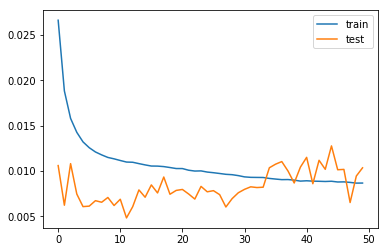

Trend.Error: 0.50 / 32


In [113]:
params = read_parameters()
raw_dataset = read_dataset(params)
# params['lstm_batch_size'] = bs
# params['test_numbatches'] = int(round(100.0 / params['lstm_batch_size']))
adjust_parameters(params)

inv_y, inv_yhat, rmse, trend_error = run_pipeline(raw_dataset, params, plot_history=True)
print('Trend.Error: {:0.02f} / {:d}'.format((trend_error/(len(inv_y))), len(inv_y)))

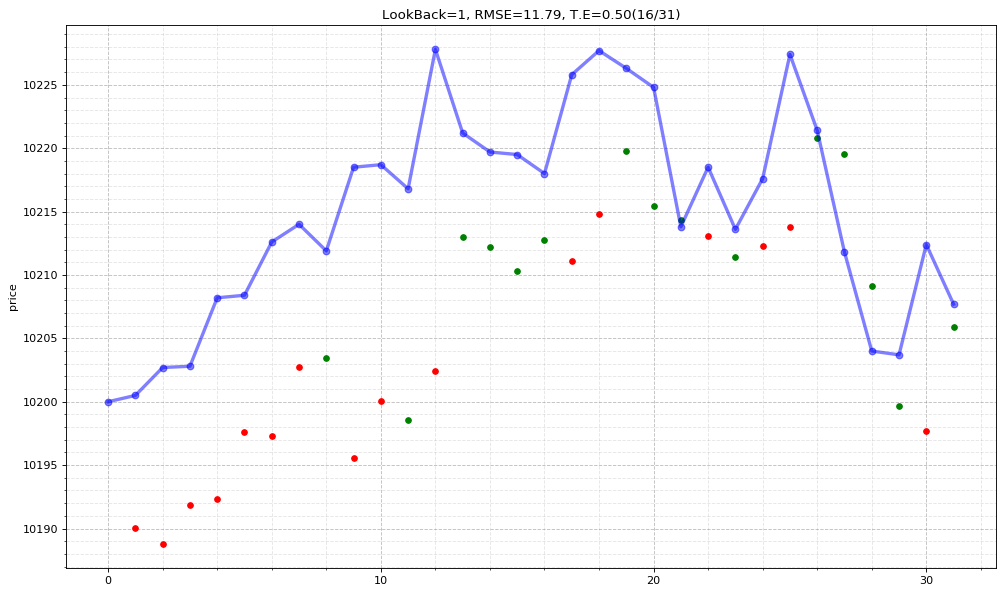

In [114]:
plot_prediction(inv_y, inv_yhat, title='LookBack={:d}, RMSE={:.02f}, T.E={:.02f}({:d}/{:d})'.
              format(params['look_back'], rmse, (trend_error/(len(inv_y))), trend_error, len(inv_y)-1))

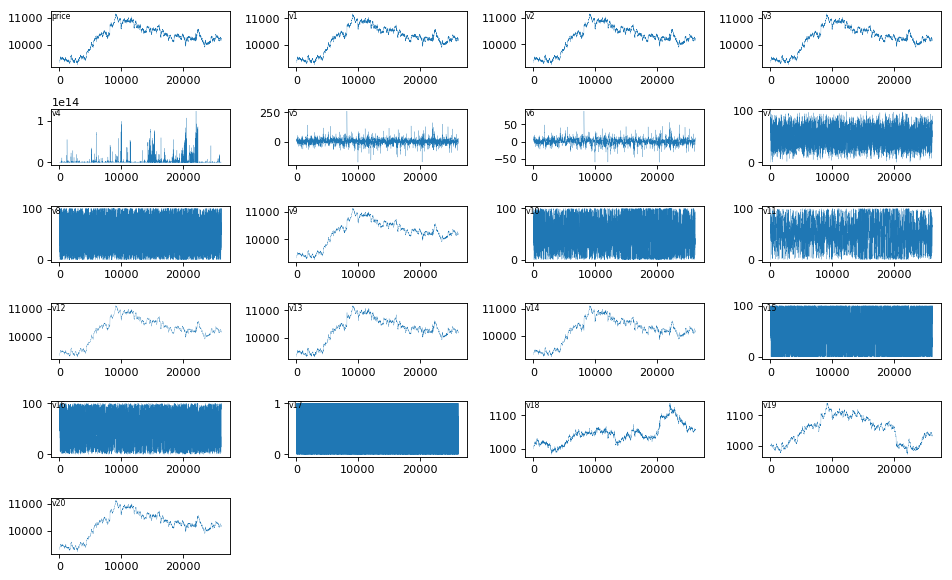

In [28]:
plot_features(raw_dataset)

In [109]:
model.evaluate(text_X, test_y)

NameError: name 'model' is not defined